# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-Global-HIF-1-response" data-toc-modified-id="Enrichment-Analysis-of-the-Global-HIF-1-response-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Enrichment Analysis of the Global HIF-1 response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analyses-of-the-egl-9-transcriptome" data-toc-modified-id="Enrichment-Analyses-of-the-egl-9-transcriptome-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Enrichment Analyses of the <em>egl-9</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-vhl-1-transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-vhl-1-transcriptome-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Enrichment Analysis of the <em>vhl-1</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-hif-1-exclusive-transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-hif-1-exclusive-transcriptome-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Enrichment Analysis of the <em>hif-1</em> exclusive transcriptome</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np
from IPython.core.display import HTML

# stats
import sklearn.decomposition
from scipy import stats as sts
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import statsmodels.api as stm

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


# bokeh
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html


# bayes and mcmc
import pymc3 as pm
import theano

# Display graphics in this notebook
bokeh.io.output_notebook()

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

Loading BokehJS ...

In [2]:
tissue_df = tea.fetch_dictionary()

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

sort_pairs = {'eb': 1, 'be': 1,
              'ed': 2,'de': 2,
              'ec': 3,'ce': 3,
              'eg': 4,'ge': 4,
              'bd': 5,'db': 5,
              'cb': 6,'bc': 6,
              'bg': 7, 'gb': 7,
              'cd': 8,'dc': 8,
              'dg': 9,'gd': 9,
              'cg': 10,'gc': 10
             }

decode_pairs = {'eb': '\emph{rhy-1}, \emph{egl-9}',
                'be': '\emph{rhy-1}, \emph{egl-9}',
                'ed': '\emph{rhy-1}, \emph{vhl-1}',
                'de': '\emph{rhy-1}, \emph{vhl-1}',
                'ec': '\emph{rhy-1}, \emph{hif-1}',
                'ce': '\emph{rhy-1}, \emph{hif-1}',
                'eg': '\emph{rhy-1}, \emph{fog-2}',
                'ge': '\emph{rhy-1}, \emph{fog-2}',
                'bd': '\emph{egl-9}, \emph{vhl-1}',
                'db': '\emph{egl-9}, \emph{vhl-1}',
                'cb': '\emph{egl-9}, \emph{hif-1}',
                'bc': '\emph{egl-9}, \emph{hif-1}',
                'bg': '\emph{egl-9}, \emph{fog-2}',
                'gb': '\emph{egl-9}, \emph{fog-2}',
                'cd': '\emph{vhl-1}, \emph{hif-1}',
                'dc': '\emph{vhl-1}, \emph{hif-1}',
                'dg': '\emph{vhl-1}, \emph{fog-2}',
                'gd': '\emph{vhl-1}, \emph{fog-2}',
                'cg': '\emph{hif-1}, \emph{fog-2}',
                'gc': '\emph{hif-1}, \emph{fog-2}'
               }

In [3]:
q = 0.1

In [4]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# # load all the beta values for each genotype:
# sleuth_loc = '../sleuth/'
# thomas.add_betas(sleuth_loc, 'betas.csv', combs)

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [5]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [6]:
df1 = thomas.beta['f'].copy()
df2 = thomas.beta['c']
df3 = thomas.beta['e']
df4 = thomas.beta['b']
df5 = thomas.beta['a'] 
df6 = thomas.beta['d']

df1['b_c'] = df2.b
df1['b_e'] = df3.b
df1['b_b'] = df4.b
df1['b_a'] = df5.b
df1['b_d'] = df6.b

df1['se_b_c'] = df2.se_b
df1['se_b_e'] = df3.se_b
df1['se_b_b'] = df4.se_b
df1['se_b_a'] = df5.se_b
df1['se_b_d'] = df6.se_b

df1['q_c'] = df2.qval
df1['q_e'] = df3.qval
df1['q_b'] = df4.qval
df1['q_a'] = df5.qval
df1['q_d'] = df6.qval

# significant in all comparisons
changes = (df1.q_e < 0.1) & (df1.q_b < 0.1) & (df1.q_d < 0.1) & (df1.q_a < 0.1)
shldntchnge = (df1.qval > 0.1)
hyp_response = changes & shldntchnge
df1[hyp_response][['ext_gene', 'b_d', 'q_d']].shape

(274, 3)

In [7]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')

# Enrichment Analysis of the Global HIF-1 response

In [8]:
teaH = tea.enrichment_analysis(df1[hyp_response].ens_gene.unique(), tissue_df, show=False)
peaH = tea.enrichment_analysis(df1[hyp_response].ens_gene.unique(), phenotype_df, show=False)
geaH = tea.enrichment_analysis(df1[hyp_response].ens_gene.unique(), go_df, show=False)

In [9]:
geaH

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
123,oxoacid metabolic process GO:0043436,5.508929,19,3.448947,0.000001,0.000287
149,immune system process GO:0002376,4.878479,17,3.484693,0.000003,0.000323
108,iron ion binding GO:0005506,1.816295,10,5.505713,0.000002,0.000323
168,cytoplasm GO:0005737,48.769779,78,1.599351,0.000028,0.001912
160,catabolic process GO:0009056,12.068606,27,2.237209,0.000049,0.002645
66,mitochondrion GO:0005739,8.135802,20,2.458270,0.000097,0.004369
68,glycosyl compound metabolic process GO:1901657,2.446745,9,3.678357,0.000197,0.007584
163,"oxidoreductase activity, acting on CH-OH group...",0.855610,5,5.843783,0.000214,0.007584
115,nucleoside phosphate metabolic process GO:0006753,3.782698,11,2.907978,0.000493,0.014793
73,lytic vacuole GO:0000323,1.395996,6,4.298008,0.000524,0.014793


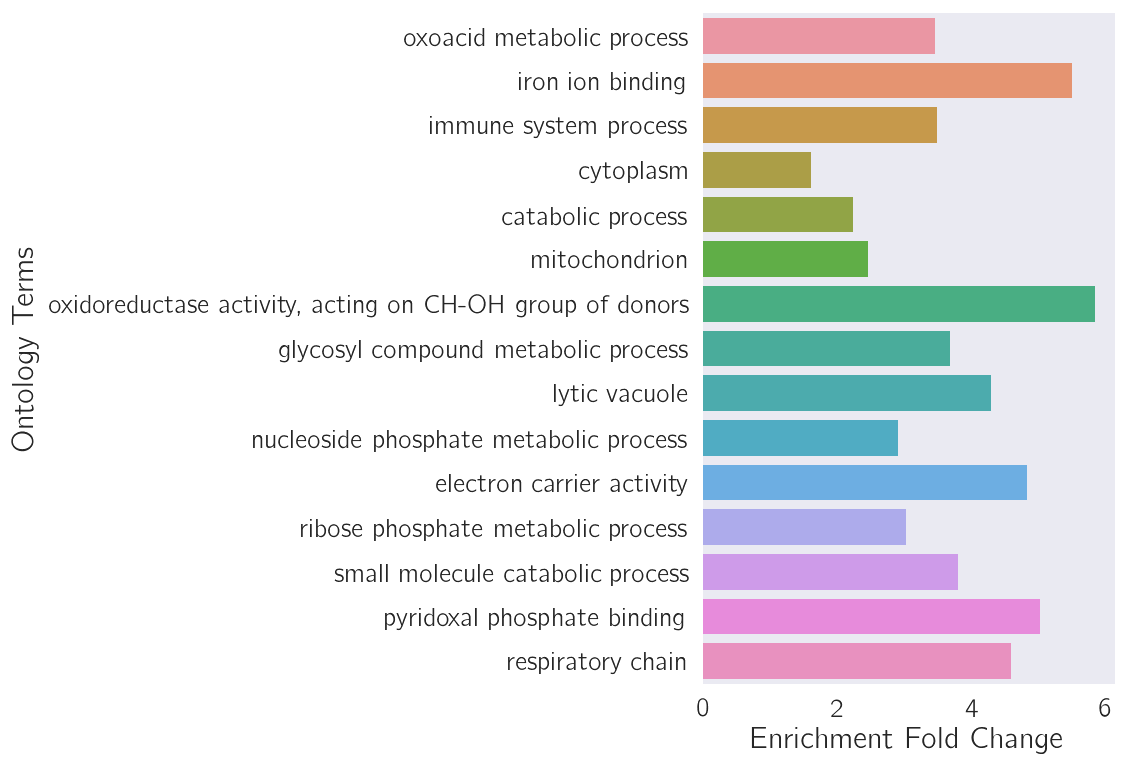

In [10]:
tea.plot_enrichment_results(geaH, analysis='go')

In [11]:
teaH

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
76,cephalic sheath cell WBbt:0008406,4.401627,13,2.953454,0.000167,0.045473


In [12]:
peaH

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
96,pleiotropic defects severe early emb WBPhenoty...,2.031332,9,4.430590,0.000040,0.007124
61,oxygen response variant WBPhenotype:0000464,1.208727,7,5.791218,0.000028,0.007124


# Enrichment Analyses of the *egl-9* transcriptome

In [13]:
egl = thomas.beta['b']
teaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), tissue_df, show=False)
peaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), phenotype_df, show=False)
geaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), go_df, show=False)

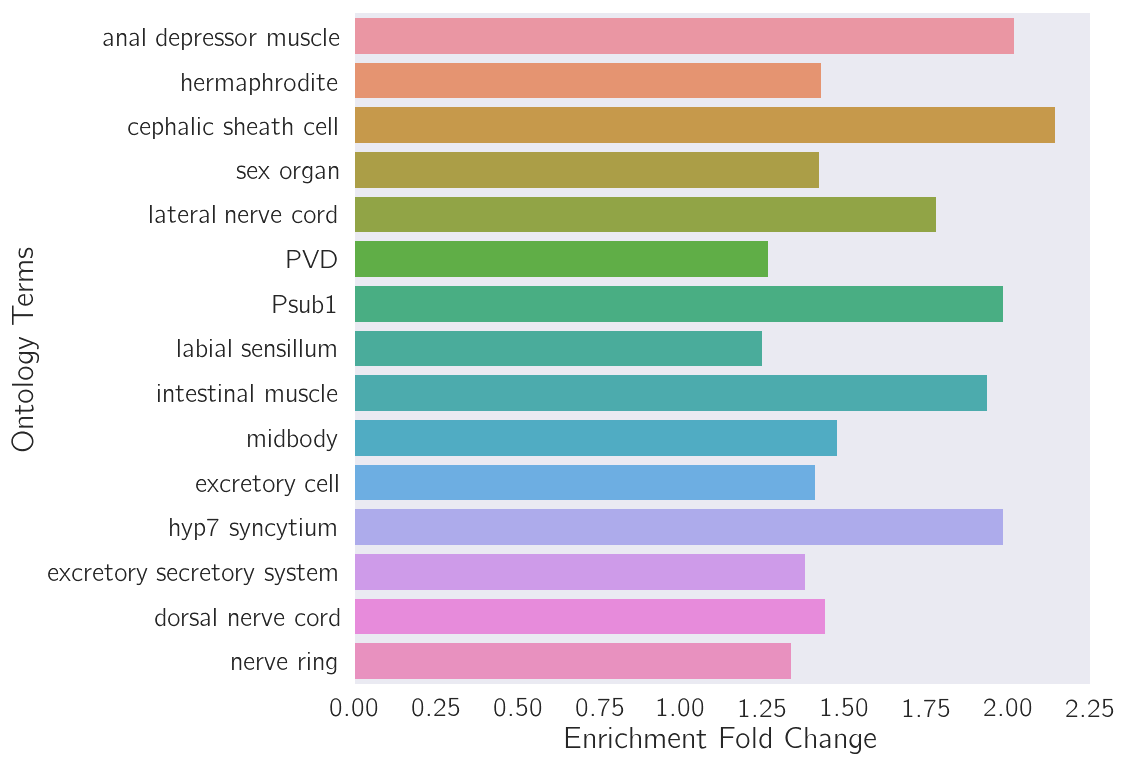

In [14]:
tea.plot_enrichment_results(teaEgl)

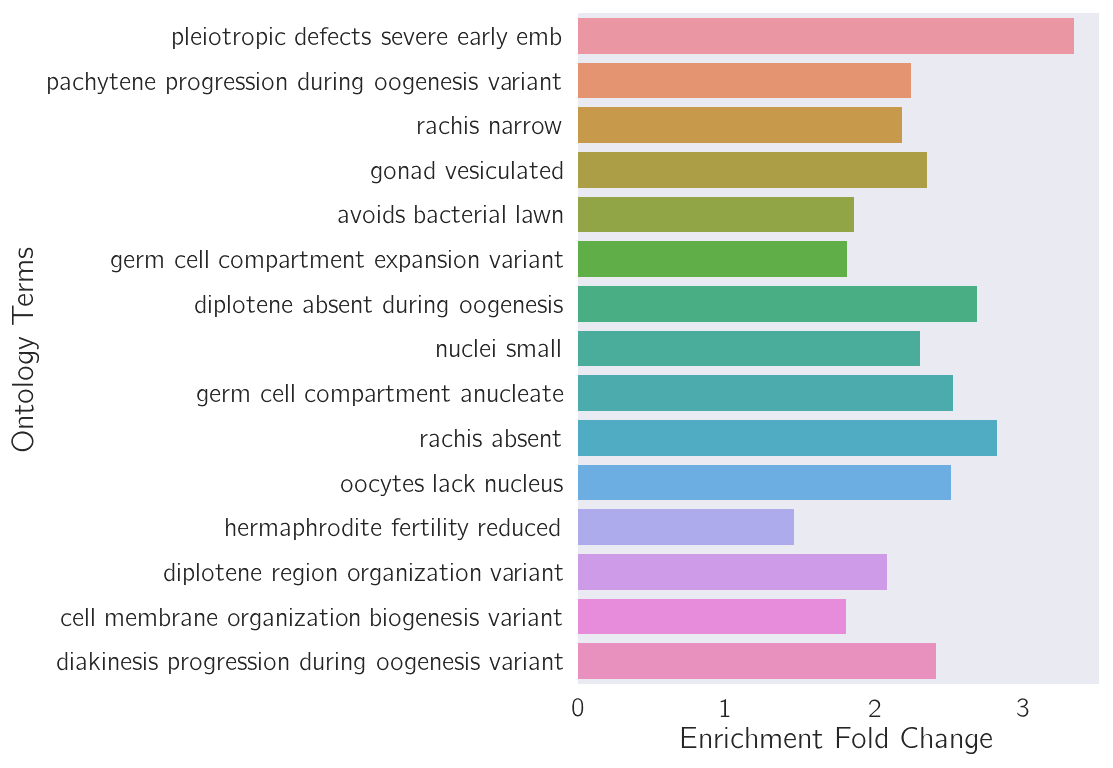

In [15]:
tea.plot_enrichment_results(peaEgl, analysis='phenotype')

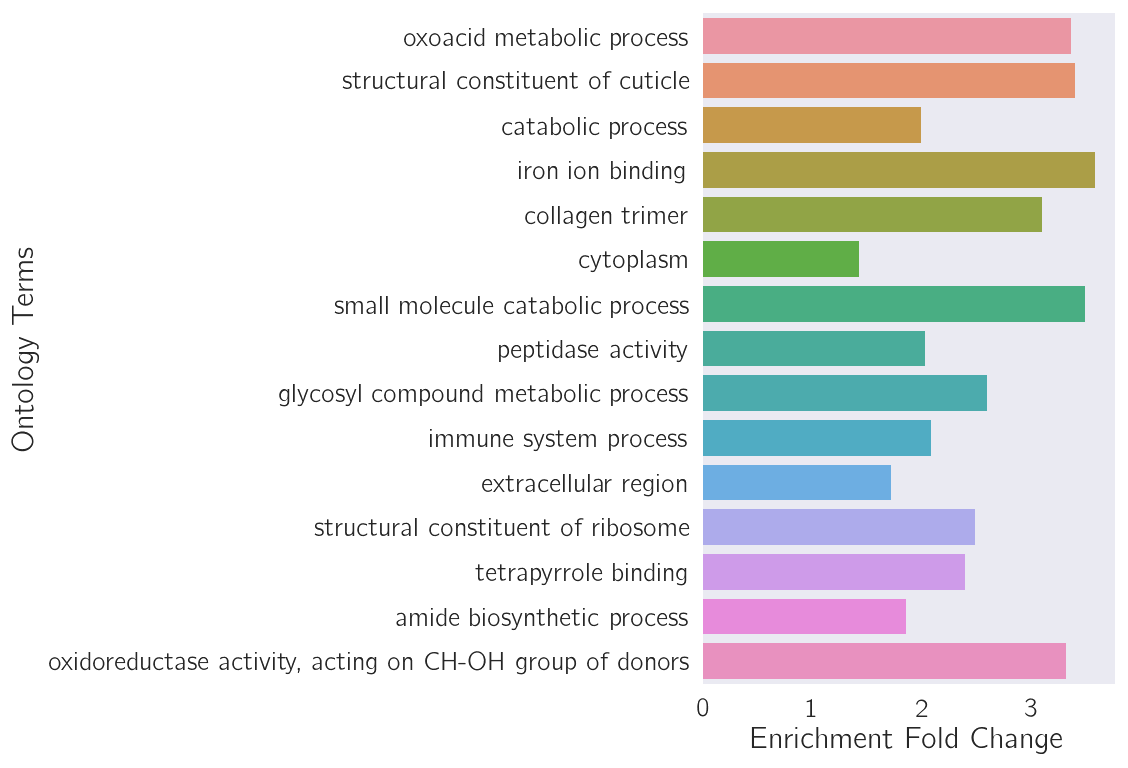

In [16]:
tea.plot_enrichment_results(geaEgl, analysis='go')

# Enrichment Analysis of the *vhl-1* transcriptome

In [17]:
vhl = thomas.beta['d']
teaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), go_df, show=False)

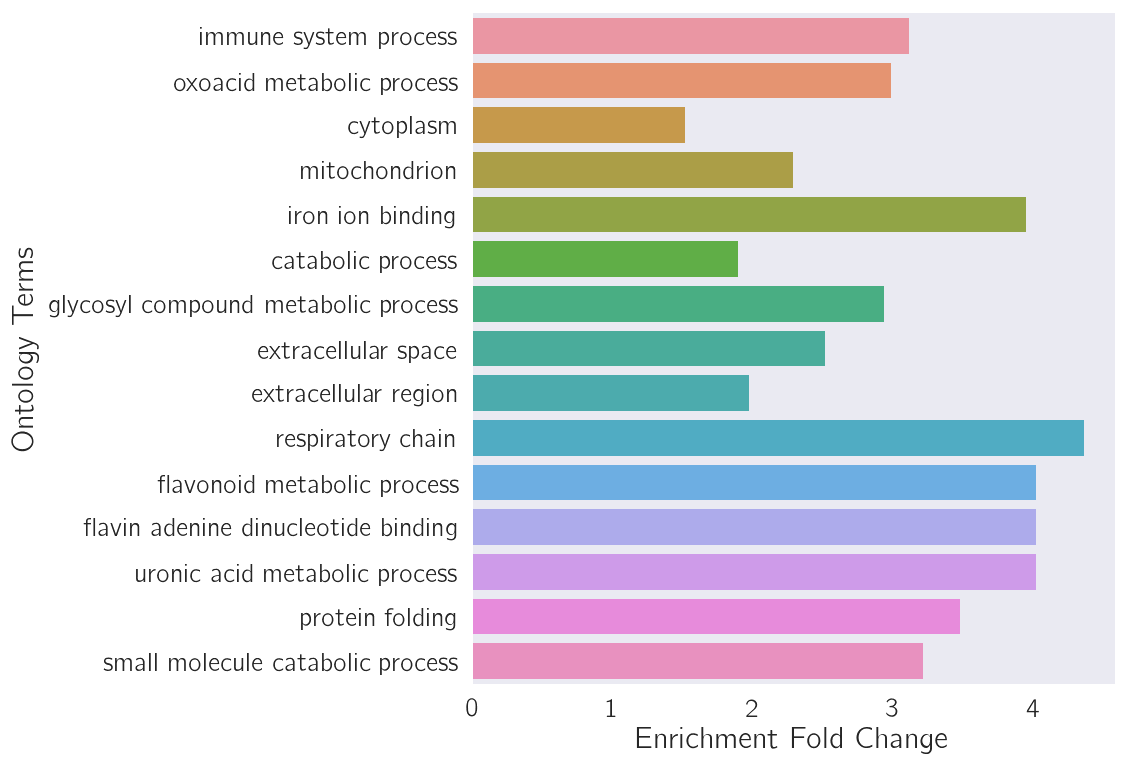

In [18]:
tea.plot_enrichment_results(geaVhl, analysis='go')

# Enrichment Analysis of the *hif-1* exclusive transcriptome

This refers to the genes that are downstream of *hif-1* but not downstream of *egl-9*, *vhl-1* or *rhy-1*.

In [19]:
hif = thomas.beta['c']
teahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), go_df, show=False)

In [20]:
tea.plot_enrichment_results(teahif, analysis='tissue')

dataframe is empty!


In [21]:
tea.plot_enrichment_results(peahif, analysis='phenotype')

dataframe is empty!


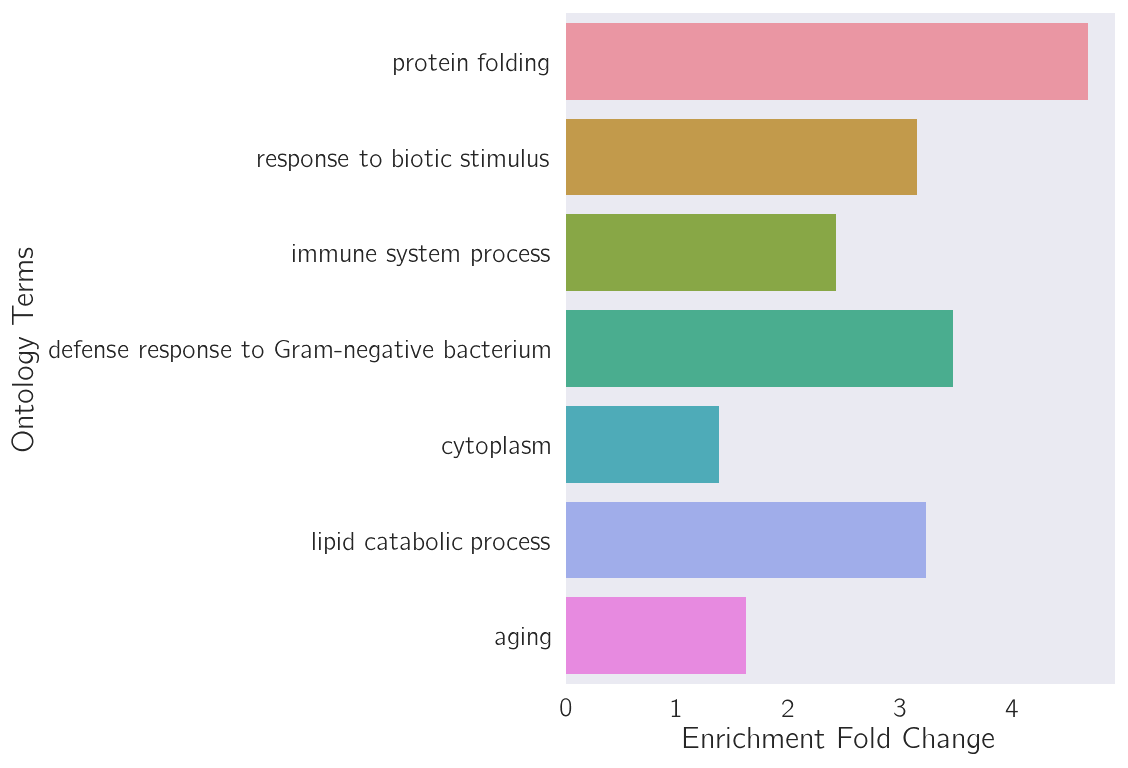

In [22]:
tea.plot_enrichment_results(geahif, analysis='go')